
# Natural Language Querying of data in S3 with Athena and Generative AI (Text-to-SQL)


In this sample notebook, you'll see how generative AI can simplify the process of querying and analyzing data stored in Amazon S3 using AWS Athena and the Glue Catalog. Instead of manually writing complex SQL queries, we'll showcase how to describe your analysis requirements in plain English text, and leverage a Generative AI model to generate the corresponding Athena SQL queries automatically.

Athena is an interactive query service that enables analysts to analyze data in S3 using standard SQL. However, constructing SQL queries, especially for complex analysis requirements, can be challenging. This is where the Glue Catalog can help - it stores table definitions and schemas for your data in S3, allowing Athena to query that data seamlessly.

This notebook illustrates how introducing generative AI can bridge the gap. 

1. Overview of text-to-SQL capabilities using GenAI models
2. Utilizing the Glue Catalog table definitions
3. Generating and executing Athena SQL queries from natural language descriptions
4. Using Generative AI for self correcting failed queries

## Prerequisites

You will need the following to execute the code in this notebook:

- Access to Athena (for query execution), S3 (read access), Glue Catalog (For Database and Tables) and Bedrock (LLMs).
- Claude 3 Sonnet Model Enabled on Bedrock. You can read more about model access here: https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html
- An S3 bucket to store the data files

# Architecture Overview

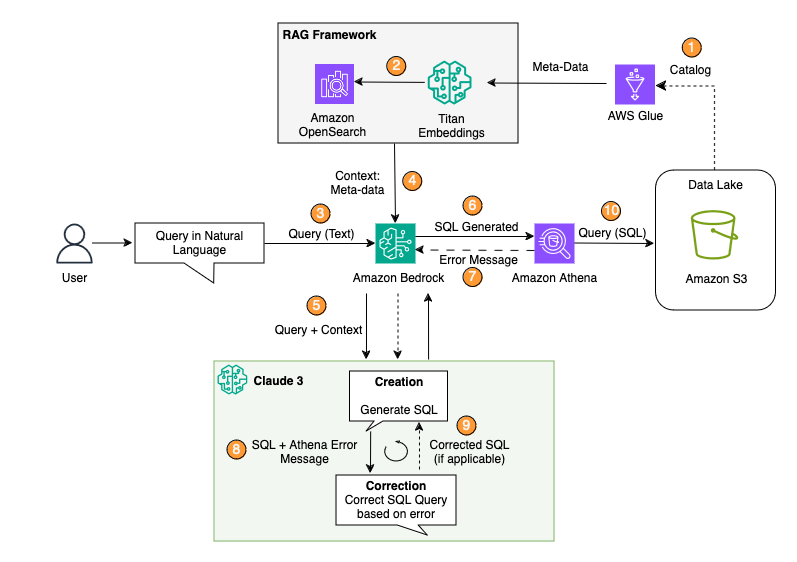



1. Create the AWS Glue Data Catalog using the AWS SDK or an AWS Glue crawler. (In this example, we will use the [AWS SDK for Pandas Library](https://github.com/awslabs/aws-data-wrangler)))

2. Use the Titan-Text-Embeddings model on Amazon Bedrock to convert the metadata into embeddings and store them in a vector store, which serves as our knowledge base in the Retrieval Augmented Generation (RAG) framework. (In this example, we use FAISS as our vector store via Langchain. Alternatively, you can use OpenSearch for a vector database. Learn more about OpenSearch Vector Database Capabilities [here](https://aws.amazon.com/blogs/big-data/amazon-opensearch-services-vector-database-capabilities-explained/))

3. The user enters their query in natural language.

4. Fetch relevant context (relevant tables) from the vector store based on the user's query.

5. Pass the user's query along with the relevant tables (context) to the Claude 3 model to generate a SQL query. This technique of retrieving context and passing it along with the question to the model is called Retrieval Augmented Generation (RAG).

6. Execute the SQL query generated by the model using Amazon Athena.

7. If Athena returns an error message (possibly due to an incorrect SQL query), proceed to the correction loop (Steps 8-9).

8. Pass the error message from Athena and the incorrect SQL query generated to the Large Language Model (LLM) to correct it.

9. The LLM creates the corrected SQL query. This iteration can be performed multiple times if needed.

10. Finally, run the corrected SQL query using Athena and present the output to the user.

### Installing the required libraries

In [ ]:
pip install awswrangler pandas boto3


## Data Preparation

Data Preparation and Exploration are crucial aspects of any Generative AI application. For this Text-to-SQL workshop we will begin with loading of sample data files and creating a data catalog as they lay the foundation for effective querying and extracting insights from data using SQL.

We will Start by installing required Python libraries AWS SDK for Pandas (awswrangler), Pandas and Boto3. AWS SDK for Pandas (awswrangler) is a Python library that simplifies the interaction between Python and the AWS ecosystem, providing a high-level API for working with a wide range of AWS services, including Amazon S3, Athena, Glue, Redshift, and DynamoDB. The library abstracts the complexity of AWS service integrations, streamlines common data engineering tasks, and integrates with other popular data science and machine learning libraries, making it a valuable tool for developers and data professionals working on AWS-based projects. For more information and references, visit [AWS Wrangler GitHub repository](https://github.com/awslabs/aws-data-wrangler)



#### Create Database and Tables in Glue Catalog

We will use AWS SDK for Pandas (awswrangler) library to interact with Glue Data Catalog and retrieve a list of all databases.

In [ ]:
import awswrangler as wr
import boto3
import pandas as pd

# List all databases in the Glue Data Catalog
databases = wr.catalog.databases()
print(databases)


Below sample code reads the customer csv file, creates a new database and table in the Glue Data Catalog, writes the data to an S3 location as a Parquet dataset, and then retrieves the first 10 rows of the table using an Athena SQL query.

Make sure you replace the "<BUCKET_NAME>" with the name of the bucket in your account.

In [ ]:
# Create catalog database: workshop_test
# Create first table (customers) in the database

bucket = "<BUCKET_NAME>"
path = f"s3://{bucket}/data/"

# Read local csv file customers.csv in to a DataFrame
df = pd.read_csv("../dataset/customers.csv")

# Check if the database workshop_test exists
if "workshop_test" not in databases.values:
    wr.catalog.create_database("workshop_test")
    print(wr.catalog.databases())
else:
    print("Database workshop_test already exists")

# List all tables in the database workshop_test
dbs = wr.catalog.tables(database="workshop_test")
# print table count

print("There are {} tables in the database workshop_test".format(len(dbs)))


print("Creating table customers in the database workshop_test")
# Create table customers in the database workshop_test
desc = "Table with list of customers"
param = {"source": "Customer Details Table", "class": "e-commerce"}

comments = {
    "customer_id": "Unique customer ID.",
    "first_name": "Customer first name.",
    "last_name": "Customer last name.",
    "email_id": "Customer email ID.",
    "phone_num": "Customer phone number.",
}

res = wr.s3.to_parquet(
    df=df,
    path=f"s3://{bucket}/customers/",
    dataset=True,
    database="workshop_test",
    table="customers",
    mode="overwrite",
    glue_table_settings=wr.typing.GlueTableSettings(description=desc, parameters=param, columns_comments=comments),
)

print("Table customers created in the database workshop_test")


# Read table customers from the database workshop_test
table = wr.catalog.table(database="workshop_test", table="customers")
print(table)


print("Records in the table customers")

# Run a sample query on the table customers
df = wr.athena.read_sql_query("SELECT * FROM customers LIMIT 10", database="workshop_test")
print(df)

In [ ]:
# Create tables for all the csv files in the dataset folder

file_names = ["orders.csv", "products.csv", "orderdetails.csv", "payments.csv", "shipments.csv", "reviews.csv"]

comments_dict = {
    "customers": {
        "customer_id": "Unique customer ID.",
        "first_name": "Customer first name.",
        "last_name": "Customer last name.",
        "email_id": "Customer email ID.",
        "phone_num": "Customer phone number.",
    },
    "orderdetails": {
        "orderdetailid": "Unique order detail ID.",
        "orderid": "Unique order ID.",
        "productid": "Unique product ID.",
        "quantity": "Quantity of product ordered.",
        "price": "Price of product.",
    },
    "orders": {
        "orderid": "Unique order ID.",
        "customerid": "Unique customer ID.",
        "orderdate": "Order date.",
        "totalamount": "Total order amount.",
    },
    "payments": {
        "paymentid": "Unique payment ID.",
        "orderid": "Unique order ID.",
        "paymenttype": "Type of payment.",
        "amount": "Payment amount.",
        "paymentdate": "Payment date.",
        "status": "Payment status.",
    },
    "products": {
        "productid": "Unique product ID.",
        "productname": "Product name.",
        "price": "Product price.",
        "category": "Product category.",
        "stock": "Product stock.",
    },
    "reviews": {
        "reviewid": "Unique review ID.",
        "productid": "Unique product ID.",
        "customerid": "Unique customer ID.",
        "rating": "Product rating.",
        "comment": "Review comment.",
        "reviewdate": "Review date.",
    },
    "shipments": {
        "shipmentid": "Unique shipment ID.",
        "orderid": "Unique order ID.",
        "status": "Shipment status.",
        "estimateddelivery": "Estimated delivery date.",
    },
}

print("Creating tables for all the csv files in the dataset folder")

for file_name in file_names:
    table_name = file_name.split(".")[0]
    df = pd.read_csv(f"../dataset/{file_name}")
    res = wr.s3.to_parquet(
        df=df,
        path=f"s3://{bucket}/{table_name}/",
        dataset=True,
        database="workshop_test",
        table=table_name,
        mode="overwrite",
        glue_table_settings=wr.typing.GlueTableSettings(
            description=f"Table with list of {table_name}.",
            parameters={"source": f"{table_name} Table", "class": "e-commerce"},
            columns_comments=comments_dict[table_name],
        ),
    )
    print(f"Table {table_name} created in the database workshop_test")
    


### Check created tables and retrieve schemas

In [ ]:
import pprint

# New Database in the Glue Data Catalog
database = "workshop_test"

# List all tables in the database workshop_test
all_tables = wr.catalog.tables(database=database)

# Get list of all table names
tables = all_tables["Table"].tolist()

print("List of all tables in the database workshop_test")
print(tables)


# Get schema for all tables
print("Schema for all tables in the database workshop_test")

all_schemas = {}
for table in tables:
    schema_str = wr.catalog.get_table_types(database=database, table=table)
    all_schemas[table] = schema_str

pprint.pprint(all_schemas)



#### Validate data load by fetching top 2 records from each table

In [ ]:
all_tables = wr.catalog.tables(database=database)
tables = all_tables["Table"].tolist()
print(tables)

for table in tables:
    data = wr.athena.read_sql_query(f"SELECT * FROM {table} LIMIT 10", database="workshop_test")
    # print first 2 rows of the data
    
    print(f"First 2 rows of the table {table}")
    print(data.head(2))
    



# Generative AI using Bedrock

Amazon Bedrock is a fully managed service that makes FMs from leading AI startups and Amazon available via an API, so you can choose from a wide range of FMs to find the model that is best suited for your use case. With Bedrock's serverless experience, you can get started quickly, privately customize FMs with your own data, and easily integrate and deploy them into your applications using the AWS tools without having to manage any infrastructure.

#### Create Bedrock Client

We will first create a boto3 bedrock client. We can use this client to issue API calls to Generative AI models available in Bedrock.

Note: You can replace the profile_name with the profile name that is configured on your developer environment that has access to Bedrock.

In [ ]:

from botocore.config import Config
import json
retry_config = Config(
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )
session = boto3.Session(region_name='us-east-1', profile_name='default')
bedrock_client = session.client(
        service_name='bedrock-runtime',
        config=retry_config
    )

print("boto3 Bedrock client successfully created!")

############################
# Note: You can also create a boto3 session with the credentials from environment variables
############################

# # Get the AWS credentials from environment variables
# AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
# AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
# AWS_SESSION_TOKEN = os.environ.get('AWS_SESSION_TOKEN', None)  # Optional, if using temporary credentials

# # Create a boto3 session with the credentials from environment variables
# session = boto3.Session(
#     aws_access_key_id=AWS_ACCESS_KEY_ID,
#     aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
#     aws_session_token=AWS_SESSION_TOKEN,  # Include this line only if using temporary credentials
# )


#### Creating a function to call Bedrock API

Next, we create a resuable function that uses the client we created above to call Claude 3 Sonnet model on Bedrock. We can pass prompt and temperature to this function.

In [ ]:
def call_bedrock_claude_3(prompt_text, temperature):
    model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
    body = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "messages": [
            {
                "role": "user",
                "content": [
                        {
                            "type": "text",
                            "text": prompt_text
                        }
                ]
            }
        ]
    }
    body = json.dumps(body)
    response = bedrock_client.invoke_model(
            body=body, modelId=model_id
        )
    # Parse the response
    response_lines = response['body'].readlines()
    json_str = response_lines[0].decode('utf-8')
    json_obj = json.loads(json_str)
    result_text = json_obj['content'][0]['text']
    
    return result_text



#### Test a sample bedrock call

In [ ]:
# Using Claude 3 Sonnet model
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
prompt = "Hello..."

# Call Bedrock and get the response
response = call_bedrock_claude_3(prompt, 0.7)
print(response)



# Text to SQL with Generative AI

Next, we'll showcase how to use generative AI models like Claude 3 to automatically generate SQL queries for analyzing data in Amazon S3 using Athena. We'll provide the AI model with the table schemas from the Glue Catalog and a natural language question describing the desired analysis. The model will then generate the corresponding Athena SQL query, which we can execute to retrieve the results. We'll also build an interactive chat widget that allows you to enter questions in plain English and see the AI-generated SQL queries and their output displayed interactively.


#### Testing SQL generation and execution

We will start by creating a schemas dict which has list of all tables and corresponding columns.


In [ ]:
import pprint

database = "workshop_test"

# List all tables in the database workshop_test
all_tables = wr.catalog.tables(database=database)

tables = all_tables["Table"].tolist()

print("List of all tables in the database workshop_test")
print(tables)


# Get schema for all tables
print("Schema for all tables in the database workshop_test")

all_schemas = {}
for table in tables:
    schema_str = wr.catalog.get_table_types(database=database, table=table)
    all_schemas[table] = schema_str

pprint.pprint(all_schemas)






We can now create a simple prompt with placeholders for tables (schemas) and question. We will then format the prompt by inserting table schemas and question and invoke Claude model on Bedrock to generate SQL query. Finally, we will execute the SQL query using Athena.

Note: We will use call_bedrock function created in the previous cells to invoke the model.

In [ ]:
# Simple SQL generation prompt
prompt = """Given the following list of tables, generate syntactically correct SQL query to answer the following question. \n\n
Tables: \n
{tables} \n\n

Question: \n
{question} \n\n

Strict Instructions: \n
- Always end with a semicolon. \n\n
- Only include the SQL query in the response. \n\n
- Always name all columns in the query. \n\n
SQL:
"""


question = "What is the total number of customers?"

# Format the prompt
prompt = prompt.format(tables=all_schemas, question=question)

print(prompt)

# Call Bedrock and get the response
sql = call_bedrock_claude_3(prompt, 0.7)
print(sql)

# Run the generated SQL query
df = wr.athena.read_sql_query(sql, database=database)
df


#### Creating a text-to-sql chat widget

We will now create a simple text-to-sql chat widget that can run within a notebook environment.

In [ ]:
pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Create text output widget for displaying messages
output = widgets.Output()
base_prompt = """Given the following list of tables, generate syntactically correct SQL query to answer the following question. \n\n
Tables: \n
{tables} \n\n
Question: \n
{question} \n\n

Strict Instructions: \n
- Always end with a semicolon. \n\n
- Only include the SQL query in the response. \n\n
- Always name all columns in the query. \n\n
SQL:
"""



# Create a text input widget
input_text = widgets.Text(
    placeholder='Type your question here...',
    description='Question:',
    disabled=False
)

# Create a button widget for sending messages
send_button = widgets.Button(
    description='Send',
    button_style='',
    tooltip='Click to send your message',
    icon='paper-plane'
)

# Create a button widget for clearing output
clear_button = widgets.Button(
    description='Clear',
    button_style='',
    tooltip='Clear output',
    icon='trash'
)

# Create a label for displaying loading status
loading_label = widgets.Label(value='')

# Function to handle sending message when button is clicked
def on_send_button_clicked(b):
    global base_prompt
    global model_id
    global all_schemas
    with output:
        output.clear_output()
        loading_label.value = 'Processing...'
    display(loading_label)
    prompt = base_prompt.format(tables=all_schemas, question=input_text.value)  # Replace 'Your_Tables_Here' with actual table list
    sql = call_bedrock_claude_3(prompt, 0.7)
    print(sql)
    df =  wr.athena.read_sql_query(sql, database="workshop_test")
    with output:
        display(df)
        display(sql)
    input_text.value = ''  # Clear the input field after sending
    loading_label.value = ''

# Function to clear the output
def on_clear_button_clicked(b):
    with output:
        output.clear_output()
    loading_label.value = ''

# Bind the buttons to their respective functions
send_button.on_click(on_send_button_clicked)
clear_button.on_click(on_clear_button_clicked)

# Display the widgets
display(input_text, send_button, clear_button, output)





# Using RAG to fetch table metadata



Now, we will explore the use of the Retrieval Augmented Generation (RAG) approach to efficiently fetch relevant table metadata from a database based on a user's natural language query. This approach leverages the power of vector databases and language model embeddings to retrieve only the most relevant tables and their associated metadata, rather than processing and passing all table metadata for every query.

The process begins by hydrating a vector database with the table metadata fetched from the AWS Glue Catalog. This metadata includes table names, descriptions, and schemas. By using natural language embeddings and similarity searches, the RAG approach can understand the context of the user's question and retrieve the most relevant tables from the vector database.

This approach offers several advantages over traditional methods:

1. **Efficiency**: Instead of processing all table metadata for every query, the RAG approach only works with the relevant subset of tables, reducing computational overhead and improving response times.

2. **Scalability**: As the number of tables in the database grows, the RAG approach remains efficient, as the retrieval process is not affected by the total number of tables.

3. **Context-awareness**: By leveraging natural language embeddings and similarity searches, the RAG approach can understand the context of the question and retrieve relevant tables, even if the table names or descriptions do not exactly match the query's wording.

4. **Flexibility**: This approach can be applied to various scenarios where specific information needs to be extracted or queried from large data sources, enabling more accurate and context-aware responses.

By combining language models, vector databases, and targeted retrieval techniques like RAG, this next section demonstrates a powerful and scalable solution for intelligent data exploration and querying, particularly in scenarios with large and complex data sources.

We will use FAISS as our vector store and langchain framework to create and hydrate the vector database. 

In [ ]:
pip install faiss-cpu langchain_community

The below code first retrieves list of all tables in the database, and then creates a dictionary that maps the table names to their descriptions.It then iterates over the list of tables, and for each table, it retrieves the schema and adds it to a dictionary `all_schemas`, which also includes the table name and description for each table.

In [ ]:
import pprint
database = "workshop_test"

# List all tables in the database workshop_test
all_tables = wr.catalog.tables(database=database)

# Get list of all table names and descriptions and create a dictionary
# format: {table_name: table_description}
tables = all_tables["Table"].tolist()
table_desc = all_tables["Description"].tolist()
table_dict = dict(zip(tables, table_desc))

print(table_dict)

# Get schema for all tables

all_schemas = {}
for table in tables:
    schema_str = wr.catalog.get_table_types(database=database, table=table)
    all_schemas[table] = {"table_description": table_dict[table], "table_name": table, "schema": schema_str}

pprint.pprint(all_schemas)





We will now use Amazon Titan Embeddings model to vectorize each table (and it's schema) and store it in FAISS Vector Database. We will use Langchain Framework to make the code simpler. We will then use similarity_search function to retrive relevant tables for a given natural language question.

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings.bedrock import BedrockEmbeddings
from langchain_community.docstore.document import Document

# Create BedrockEmbeddings object
embeddings = BedrockEmbeddings()

#create document from schemas. Each document represents a table schema
documents = []
for table, schema in all_schemas.items():
    doc = Document(page_content=str(schema), metadata={"table": table})
    documents.append(doc)

print(documents)

# Create FAISS index from the documents
db = FAISS.from_documents(documents, embeddings)
print(db.index.ntotal)

# Search for tables relevant to the query "total number of orders"
relevant_tables = db.similarity_search("total number of orders")
print(relevant_tables)




#### SQL Generation with selective metadata fetched using RAG

We will use the same prompt as before, but we will now only pass the relevant table schemas to the model.


In [ ]:
# Simple SQL generation prompt
prompt = """Given the following list of tables, generate syntactically correct SQL query to answer the following question. \n\n
Tables: \n
{tables} \n\n
Question: \n
{question} \n\n

Strict Instructions: \n
- Always end with a semicolon. \n\n
- Only include the SQL query in the response. \n\n
- Always name all columns in the query. \n\n
SQL:
"""

question = "What is the total number of orders per customer?"

# Search for relevant tables based on the question
sim_search = db.similarity_search(question)

print("Relevant tables for the question: ", sim_search)

tables_str = ""

# Get table names and schema for the relevant tables
for table in sim_search:
    tables_str += table.page_content + "\n"

print(tables_str)

# Format the prompt
prompt = prompt.format(tables=tables_str, question=question)

# Call Bedrock and get the response
sql = call_bedrock_claude_3(prompt, 0.7)
print(sql)

# Run the generated SQL query
df = wr.athena.read_sql_query(sql, database=database)
df




# Self Correction Loop

In a text-to-SQL system powered by generative AI, a self-correction loop can be implemented to iteratively correct/refine the generated SQL queries. The process begins with the user providing a natural language request, which the AI model translates into an initial SQL query. The query is then executed against the target database, and the results are evaluated. If the query is unsuccessful or the results do not match the user's intent, the system enters a feedback loop, analyzing the failure mode and using it to update the AI model. The refined query is then re-executed, and the loop continues until a satisfactory result is achieved. This self-correcting mechanism allows the system to learn from its mistakes, improving the quality and accuracy of the generated SQL over time, while also incorporating user feedback to better align the output with their specific needs and the target database schema.

#### Simulating error

In [ ]:
# query with wrong column name
incorrect_sql = "SELECT firstname FROM customers"
try:
    results = wr.athena.read_sql_query(incorrect_sql, database=database)
except Exception as e:
    print(f"Error: {e}")


#### Auto correction and execution

In the below code, we will create a new prompt which instructs the model to correct a failing query. We pass the list of tables, the failing query and error returned by Athena.

In [ ]:
question = "List all the first names of the customers."

# SQL correction prompt
correction_prompt = """
Given an incorrect SQL query, error code, table information and a question, generate a syntactically correct SQL query to answer the question.

Incorrect SQL Query:
{incorrect_sql}

Tables:
{tables}

Question:
{question}

Error Code:
{error_code}

Strict Instructions:
- Always end with a semicolon.
- Only include the SQL query in the response.
- Always name all columns in the query.
"""

try:
    # Run the incorrect SQL query
    results = wr.athena.read_sql_query(incorrect_sql, database=database)
except Exception as e:
    # Handle the error
    print(e)

    # Error code returned by Athena
    error_code = str(e)

    # Search for relevant tables based on the question
    sim_search = db.similarity_search(question)
    tables_str = ""

    # Get table names and schema for the relevant tables
    for table in sim_search:
        tables_str += table.page_content + "\n"


    # Format the SQL correction prompt
    prompt = correction_prompt.format(incorrect_sql=incorrect_sql, tables=tables_str, question=question, error_code=error_code)

    # Call Bedrock and get the corrected SQL query
    sql = call_bedrock_claude_3(prompt, 0.7)
    print(sql)

    # Run the corrected SQL query
    df = wr.athena.read_sql_query(sql, database=database)
    print(df)
    


# Conclusion

Generative AI models have demonstrated remarkable capabilities in understanding natural language and generating structured outputs like SQL queries. This text-to-SQL capability leverages large language models trained on vast amounts of data, including code repositories, documentation, and query logs, to learn the mappings between natural language descriptions and their corresponding SQL representations. By processing human-readable inputs, such as analysis requirements or data exploration prompts, these models can generate SQL queries that accurately capture the intended data operations. This not only simplifies the querying process for non-technical users but also enhances productivity for data professionals by automating the translation from natural language to SQL. Additionally, generative AI models can iteratively refine and self-correct queries based on feedback, enabling more accurate and efficient data interactions. The text-to-SQL capability of generative AI has the potential to democratize data access, improve data literacy, and accelerate data-driven decision-making across various industries and applications.